# Chapter 3. 결정 트리 (Decision Tree)
태초의 머신러닝 알고리즘이라 할 수 있는 퍼셉트론은 태생적으로 아주 큰 한계에 직면했습니다. 이를 극복하기 위해 경사 하강법의 도입을 통한 아달린 모델, 이를 한 번 더 강화한 미니배치 학습법과 확률적 경사 하강법, 시그모이드 함수를 통해 확률적 예측 모델을 적용한 로지스틱 회귀까지 참 다양한 모델을 개발해왔죠. 그리고 이와 비슷한 시기에, 분류 문제에 특화된 모델을 만들고자 퍼셉트론과는 근본적인 원리가 다른 또다른 시도가 이루어졌습니다. 그리고 뜻밖에도 이 모델이 머신러닝 분야의 또다른 활로를 열어줬다는 평가를 받게 됩니다. 이번 수업에서는 이렇게 해서 태어난 또다른 모델인 결정 트리에 대해 알아보겠습니다.

## 3.1 결정 트리의 원리
결정 트리는 일련의 질문에 대한 결정을 통해 데이터를 분해하는 모델입니다. 쉽게 설명하자면 **스무고개**를 통한 분류 문제의 해결을 도모한 것입니다. 예를 들어 붓꽃 데이터셋에서 꽃받침 너비라는 특성 축에 기준 값을 2.8cm라고 했다고 해봅시다. "꽃받침 너비가 2.8cm 이상인가요?"라는 질문에 우리는 예/아니오로 대답할 수 있습니다. 프로그래밍 언어에서도 이 정도는 쉽게 구현할 수 있을 것이라고 짐작할 수 있습니다.
이러한 **결정 알고리즘**을 사용하면 첫번째 질문에서 시작해서 우리가 원하는 만큼 데이터 모집단을 분할할 때까지 질문을 거듭할 수 있습니다. 이것이 마치 나무처럼 아래로 뻗어나가기 때문에 트리(tree)라는 이름이 붙은 것이죠.
결정 알고리즘은 첫 번째 질문, 통칭 루트(root, 즉 뿌리)에서 시작해 정보 이득(Information Gain, IG)이 최대가 되는 특성으로 데이터를 분할합니다. 정보 이득에 대해서는 별도의 문서에서 설명하도록 하죠. 반복 과정을 통해 이파리 또는 가지에 해당하는 리프 노드(leaf node)가 순수해질 때까지, 즉 어떤 질문에 대한 대답이 여러 클래스가 섞이지 않고 한 가지 분류만 모아져 있도록 분할을 반복합니다. 즉, 각 노드의 모든 훈련 샘플은 동일 클래스에 속합니다.
문제는 이렇게 하면 노드가 많은 깊은 트리가 만들어지고 오버피팅이 일어날 가능성이 높습니다. 일반적으로 트리의 최대 깊이를 제한하여 트리를 가지치기(prune)하게 됩니다.

## 3.2 결정 트리 만들기
결정 트리는 특성 공간을 사각 격자로 나누기 때문에 복잡한 결정 경계를 만들 수 있습니다. 앞서 설명한 것처럼 트리가 깊어질수록 결정 경계가 깊어지면서 오버피팅이 일어나기 쉽기 때문에 주의해야 합니다. 이번 예제에서는 사이킷런을 사용하여 최대 깊이가 4인 결정 트리를 훈련해보겠습니다. 결정 트리 알고리즘은 특성의 스케일을 조정할 필요가 없지만(즉, 표준화나 정규화 과정 불필요) 그래프의 표현을 위해서 조정할 수 있습니다. 노드를 나누는 기준은 지니 불순도(gini impurity)라는 지표를 기준으로 합니다.  
> <span style='background-color:green'>Tips and Tricks</span><br/>결정 트리 구조는 특이하게도 내부에서 어떻게 학습이 진행되었는지 알 수 있게 해주는 여러 가지 라이브러리와 패키지를 이용할 수 있습니다. 이 단원의 학습을 시작하기 전에 먼저 아래 명령어를 통해 필요한 패키지를 설치하도록 합시다. 단, 윈도우 환경의 경우 graphviz는 후술하는 방법대로 공식 홈페이지에서 설치 프로그램을 다운받아 설치한 후 재부팅을 해야 합니다.
```Bash
$ pip install pydotplus
$ pip install graphviz
$ pip install pyparsing
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [4]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor=None if idx==1 else 'black')

    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        # 모든 샘플을 그립니다.
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    facecolor='none',
                    edgecolor='black',
                    alpha=1.0, linewidth=1,
                    marker='o', s=100, 
                    label='test set')

In [5]:
tree_model = DecisionTreeClassifier(criterion='gini',
                                    max_depth=4,
                                    random_state=1)

In [6]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [7]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

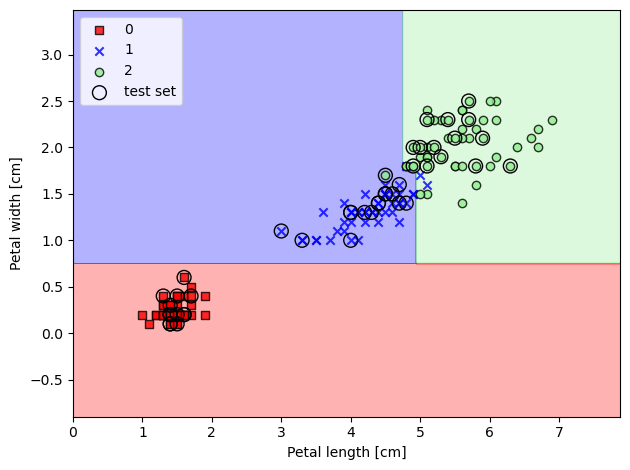

In [8]:
plot_decision_regions(X_combined, y_combined,
                      classifier=tree_model, test_idx=range(105, 150))
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

이와 같이 코드를 실행하면 축에 나란히 놓인 전형적인 결정 트리의 경계를 얻습니다.
사이킷런에는 훈련이 끝난 결정 트리 모델을 손쉽게 시각화할 수 있는 기능들이 있습니다. 그리고 더 나은 결정 트리를 그리기 위해 서드 파티 패키지, 심지어 별도로 설치해야 하는 프로그램을 사용해 더 멋진 그림을 그릴 수도 있습니다. 몇 가지는 위에서 나온 것과 같이 pip를 통해 설치할 수 있지만, 예외적으로 GraphViz 프로그램은 [이 링크](http://www.graphviz.org/download)에서 무료로 다운로드받아서 설치해야 합니다. 

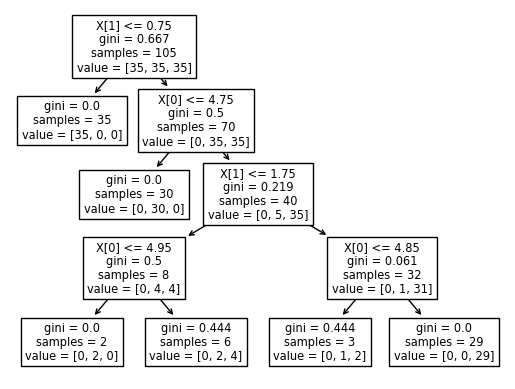

In [9]:
from sklearn import tree
tree.plot_tree(tree_model)
plt.show()

In [10]:
# 로컬 디렉터리에 PNG 포맷의 결정 트리 이미지 생성
import os
os.chdir(r"C:\Users\jktak\OneDrive\문서\P\pythonVScode\MLStudyPlaydata\MLTraining\images")
dot_data = export_graphviz(tree_model, filled=True, rounded=True,
                           class_names=['Setosa', 'Versicolor', 'Virginica'], # 분류 클래스 이름
                           feature_names=['petal length', 'petal width'], # 사용된 속성 이름
                           out_file=None) # tree.dot 중간 파일을 디스크에 만들지 않고 dot 데이터를 바로 dot_data에 할당
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

True

![결정 트리](images/tree.png)  
이 이미지를 보면 결정 트리가 훈련 데이터셋에서 선택한 분할을 손쉽게 분석할 수 있습니다. 루트 노드에서 105개의 샘플로 시작합니다. 그 다음 꽃잎 너비가 0.75cm 이하인 기준을 사용해서 35개와 70개의 샘플을 가진 두 개의 자식 노드로 분할합니다. 첫 번째 분할로 왼쪽 자식 노드는 이미 `Iris-setosa` 클래스의 샘플만 가진 순수 노드가 되었습니다(지니 불순도 = 0). 오른쪽에서는 분할이 추가로 일어나 `Iris-versicolor`와 `Iris-virginica` 클래스의 샘플을 구분합니다.  
> <span style='background-color:green'>Tips and Tricks</span><br/>`max_depth` 외에 결정 트리에서 지원하는 대표적인 사전 가지치기 설정은 다음과 같습니다.
> * `max_leaf_nodes`: 리프 노드의 최대 개수. 기본값은 `None`으로 제한이 없습니다.
> * `min_samples_leaf`: 리프 노드가 되기 위한 최소 샘플 개수나 샘플의 비율. 기본값은 1.
> * `min_samples_split`: 노드 분할을 위한 최소 샘플 개수나 샘플의 비율. 기본값은 2.
> * `min_impurity_decrease`: 노드 분할이 감소시킬 최소 불순도. 기본값은 0.
> * `min_impurity_split`: 트리 성장을 멈출 불순도 임계 값. 기본값은 0. 사이킷런 0.25 버전 이후로는 삭제되어 `min_impurity_decrease`와 통합되었습니다.

## 3.3 여러 개의 결정 트리 연결 - 랜덤 포레스트
이쯤되니 학자들은 생각하기 시작했습니다. "야, 이거 트리 여러 개를 묶어서 사용하면 성능은 더 좋아지고 오버피팅도 막을 수 있지 않겠냐?" 그리하여 여러 개의 결정 트리를 묶어서 하나의 숲(forest)을 만들어버린 랜덤 포레스트(random forest) 알고리즘이 등장했습니다. 랜덤 포레스트와 같이 여러 개의 알고리즘을 묶어서 사용하는 기법을 앙상블(ensemble) 기법이라고 하는데, 자세한 얘기는 다음 장인 4장에서 알아보기로 하고 여기서는 랜덤 포레스트가 앙상블의 일종이라는 것만 짚고 넘어가죠.
랜덤 포레스트 이면의 아이디어는 여러 개의 (깊은) 결정 트리를 학습시키고, 그 예측 결과의 평균을 취하는 것입니다. 개개의 트리는 오버피팅의 위험이 있지만, 앙상블은 일반화 성능을 높이고 오버피팅의 위험을 줄입니다. 랜덤 포레스트 알고리즘은 다음의 네 단계로 나뉩니다.  
1. $n$개의 랜덤한 부트스트랩(bootstrap) 샘플을 뽑습니다(훈련 데이터셋에서 중복을 허용하면서 랜덤하게 $n$개의 샘플을 선택합니다).
2. 부트 스트랩 샘플에서 결정 트리를 학습합니다. 각 노드에서 다음과 같이 합니다.
    a. 중복을 허용하지 않고 랜덤하게 $d$개의 특성을 선택합니다.
    b. 정보 이득과 같은 목적 함수를 기준으로 최선의 분할을 만드는 특성을 사용해 노드를 분할합니다.
3. 1 ~ 2 단계를 $k$번 반복합니다.
4. 각 트리의 예측을 모아 다수결 투표(majority voting)로 클래스 레이블을 할당합니다. 다수결 투표는 4장에서 앙상블 모델과 함께 자세히 설명합니다.  

2단계에서 각각의 결정 트리를 훈련할 때 조금 다른 점이 있습니다. 각 노드에서 최선의 분할을 찾기 위해 모든 특성을 평가하는 것이 아니라 랜덤하게 선택된 일부 특성만 사용합니다.  
이렇게 다중성과 무작위성을 조합한 덕분에 랜덤 포레스트는 결정 트리보다 해석이 어렵긴 하지만 하이퍼파라미터 튜닝에 많은 노력을 기울이지 않아도 되는 장점이 있습니다. 개별 결정 트리가 만드는 노이즈로부터 매우 안정되어 있어 가지치기를 할 필요도 없습니다. 신경써야 할 파라미터는 랜덤 포레스트가 만들 트리 개수(즉, 3단계) 하나입니다. 일반적으로 트리의 개수가 많아질수록 계산 비용이 증가하는 만큼 분류기의 성능이 좋아집니다. 
사이킷런의 `RandomForestClassifier`를 포함한 대부분의 라이브러리에서는 부트스트랩 샘플 크기를 원본 훈련 데이터셋의 샘플 개수와 동일하게 합니다. 보통 이렇게 하면 균형 잡힌 편향-분산 트레이드오프를 얻어 언더피팅과 오버피팅의 중간 지점에 학습 성능을 안착시키게 됩니다. 분할에 사용할 특성 개수 $d$는 훈련 데이터셋에 있는 전체 특성 개수보다 작게 지정하는 편입니다. 사이킷런과 다른 라이브러리에서 사용하는 적당한 기본값은 $d=\sqrt{m}$입니다. 여기서 $m$은 훈련 데이터셋의 특성 개수입니다.

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, # 트리의 개수
                                random_state=1,
                                n_jobs=1) # 학습에 사용할 CPU 코어의 개수

In [13]:
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, n_jobs=1, random_state=1)

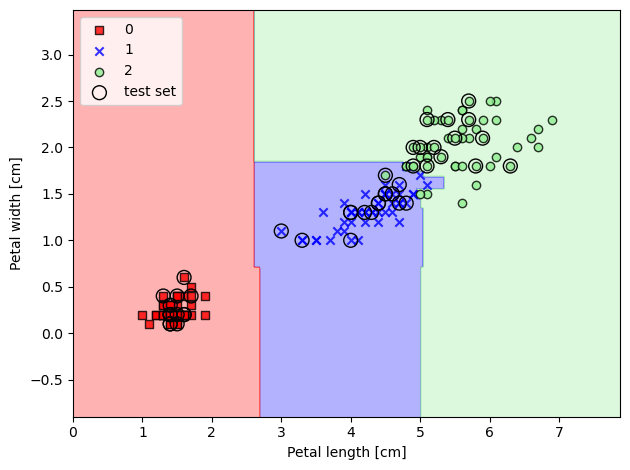

In [14]:
plot_decision_regions(X_combined, y_combined,
                      classifier=forest, test_idx=range(105, 150))
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

앞 코드를 실행하면 위 그림과 같이 랜덤 포레스트와 트리 앙상블이 만든 결정 영역을 볼 수 있습니다.